- `conda activate mri`
  - (created in `0_setup.ipynb`)

---

- `jupyter lab` => open this file

---

- Selected Jupyter default kernel (`ipykernel`)

---

---

# Observation - __Muslim et al__. MRIs:

---

- NifTi Header
  - ___Incorrect_ Voxel Sizes__
    - All 1x1x1 (mm)
      - Supplementary material indicates ~4-7mm spacing/thickness
  - __No/Default Transform/Rotation Metadata__
    - NifTi header __missing orientation/qform/sform data__
- __Incorrect Data/Array Orientation__
  - Visualization shows __90 degree axial rotation__
- Relatively Small Dimension 3 (Z Axis)
  - \# slices -> ~20's vs ~100


---

# Fix Inaccurate/Invalid Data via:

---

  - Orientation
    - Rotating the 3D array 90 degrees in the axial plane (viewed from above), such that the left-right axis (X) and the anterior-posterior axis (Y) are swapped
  - NifTi Header
    - Invalid/default values - orientation/affine matrix/coordinate system
    - `pixdim`
      - Adjusting the voxel size along the anatomical inferior-superior axis (head-to-foot direction in the subject's coordinate system) based on Supplementary Material

---

---

In [1]:
import nibabel as nib
import os
import glob

---

In [2]:
files_ms_muslim_15t = glob.glob(os.path.expanduser('~/dissertation/data/MRI/Muslim_et_al/Patient-*/*[0-9]-T2.nii'), recursive=True)
files_ms_isbi_ph3 = glob.glob(os.path.expanduser('~/dissertation/data/MRI/ISBI/training/training*/orig/*t2.nii.gz'), recursive=True)

---

---

# Orientation/Header Fix

---

- Axial (Transverse) View: A slice that divides the body into upper (superior) and lower (inferior) sections, aligned with the x-y plane.
- Coronal View: A slice that divides the body into front (anterior) and back (posterior) sections, aligned with the x-z plane.
- Sagittal View: A slice that divides the body into left and right sections, aligned with the y-z plane.


---

## Illustration of Needed Fix

---

### Header - Fix Needed 

---

In [3]:
muslim_15t = nib.load(files_ms_muslim_15t[0])
isbi_ph3 = nib.load(files_ms_isbi_ph3[0])

print(f"Muslim et al. vs ISBI\nqform_code = {muslim_15t.header['qform_code']} vs {isbi_ph3.header['qform_code']}\n")
print(f"Muslim et al. vs ISBI\nquatern_d (0 is invalid; 1 is identity) = {muslim_15t.header['quatern_d']} vs {isbi_ph3.header['quatern_d']:.5f}")


Muslim et al. vs ISBI
qform_code = 0 vs 1

Muslim et al. vs ISBI
quatern_d (0 is invalid; 1 is identity) = 0.0 vs 0.05222


---

### Imagery Data - Fix Needed

---

In [4]:
#
# function to visualize incorrect vs correct MRI orientation from axial view
#

def visualize_2_mris(img1, img2):
    import matplotlib.pyplot as plt

    data_img1 = img1.get_fdata()
    data_img2 = img2.get_fdata()
                     
    # Choose the middle slice along the z-axis
    slice_index_img1 = data_img1.shape[2] // 2
    slice_index_img2 = data_img2.shape[2] // 2
    
    # Extract the slices
    slice_data_img1 = data_img1[:, :, slice_index_img1]
    slice_data_img2 = data_img2[:, :, slice_index_img2]
    
    # Plot the slices side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot the first slice
    axs[0].imshow(slice_data_img1.T, cmap='gray', origin='lower')
    # axs[0].set_title(f"{'/'.join(img1.get_filename().split('/')[-5:])} - Slice")
    axs[0].axis('off')
    
    # Plot the second slice
    axs[1].imshow(slice_data_img2.T, cmap='gray', origin='lower')
    # axs[1].set_title(f"{'/'.join(img2.get_filename().split('/')[-5:])} - Slice")
    axs[1].axis('off')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

---

#### Visualization of Fix Needed

---

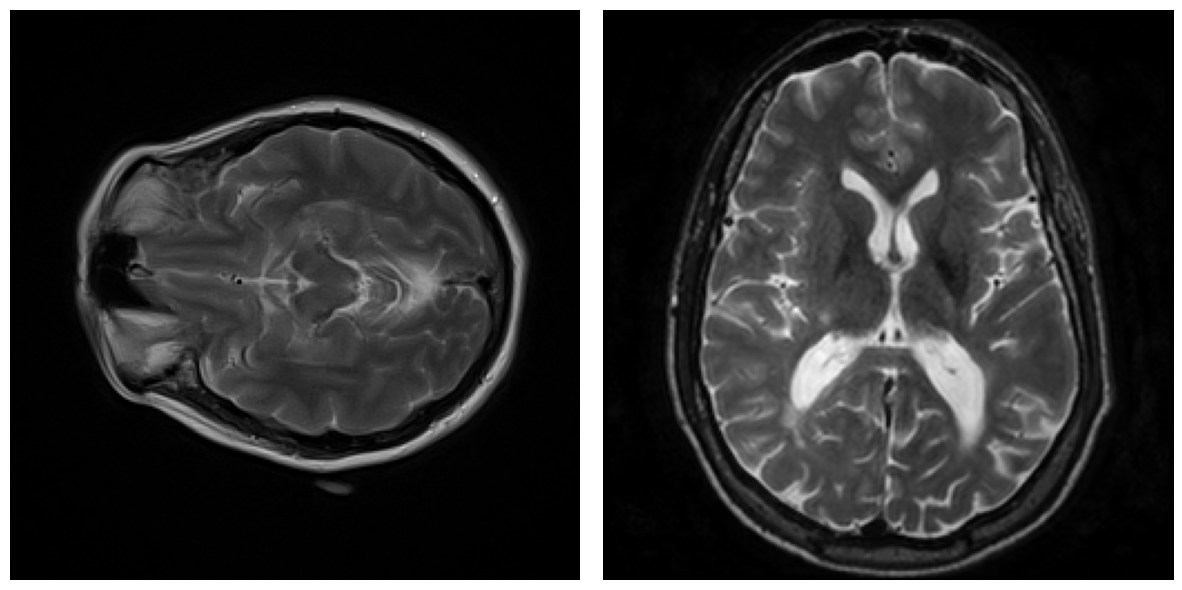

In [5]:
visualize_2_mris(
    img1 = muslim_15t, 
    img2 = isbi_ph3
)

---

__Visualization of the data show 90 degree rotation needed in dimension 3__ (from axial view)

---

## Correction Applied to MS 1.5T T2

---

(__Upon visual verification__ using the code below, __all 60 scans of 1.5T Muslim et al. T2 needed rotation__)

---

### Fix Code - Written to File and Executed

- data
  - rotate 90 degrees
    - third voxel dimension in the RAS+ (Right-Anterior-Superior) coordinate system
- header
  - `quatern_d`
      - replace invalid (`0.0`) with identity (`1.0`)
  - `qform_code`
    - `unknown` => `scanner`
   

(more comprehensive changes applied properly during subsequent voxel size adjustment)

---

---

`3-1__reorient_and_apply_identity.py`

---

In [6]:
prog = """
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from matplotlib.widgets import Button
import glob
import os

# Function to display the middle slice with an interactive correction option
def display_and_correct(file_list):
    for file_path in file_list:
        img = nib.load(file_path)
        global data
        data = img.get_fdata()

        mask_file = file_path.replace("-T2", "-LesionSeg-T2")
        assert os.path.exists(mask_file)
        mask_img = nib.load(mask_file)
        global mask_data
        mask_data = mask_img.get_fdata()

        # Display the middle slice
        mid_slice = data.shape[2] // 2
        fig, ax = plt.subplots()
        ax.imshow(data[:, :, mid_slice], cmap="gray")
        ax.set_title(f"File: {file_path.split('/')[-1]} - Middle Slice")
        plt.axis("off")

        # replace invalid 0.0 value with identity
        img.header['quatern_d']=1.0
        mask_img.header['quatern_d']=1.0
        # replace 'unknown' with 'scanner'
        img.header['qform_code']=1
        mask_img.header['qform_code']=1
        
        # Check if file already ends with "_oriented" to avoid duplicating it
        if file_path.endswith(".nii.gz") and not file_path.endswith("_oriented.nii.gz"):
            corrected_path = file_path.replace(".nii.gz", "_oriented.nii.gz")
        elif file_path.endswith(".nii") and not file_path.endswith("_oriented.nii"):
            corrected_path = file_path.replace(".nii", "_oriented.nii")
        else:
            corrected_path = file_path

        # Function to apply the rotation and save the corrected imagery/mask data
        def apply_rotation(event):
            global data, mask_data
            data = np.rot90(data, k=-1, axes=(0, 1))  # Rotate main image 90° clockwise
            mask_data = np.rot90(mask_data, k=-1, axes=(0, 1))
            continue_to_next(None)

        # Function to move to the next file
        def continue_to_next(event):
            corrected_img = nib.Nifti1Image(data, img.affine, img.header)
            nib.save(corrected_img, corrected_path)
            print(f"Saved corrected file as {corrected_path}")
        
            # Process and save the corresponding mask file
            if mask_file.endswith(".nii.gz") and not mask_file.endswith("_oriented.nii.gz"):
                corrected_mask_path = mask_file.replace(".nii.gz", "_oriented.nii.gz")
            elif mask_file.endswith(".nii") and not mask_file.endswith("_oriented.nii"):
                corrected_mask_path = mask_file.replace(".nii", "_oriented.nii")
            else:
                corrected_mask_path = mask_file
            corrected_mask_img = nib.Nifti1Image(mask_data, mask_img.affine, mask_img.header)
            nib.save(corrected_mask_img, corrected_mask_path)
            print(f"Saved corrected mask file as {corrected_mask_path}")
            plt.close(fig)  # Close current figure to move to the next file

        # Add "Apply" button and link to apply_rotation function
        ax_apply = plt.axes([0.7, 0.02, 0.1, 0.05])
        btn_apply = Button(ax_apply, 'Apply')
        btn_apply.on_clicked(apply_rotation)

        # Add "Continue" button and link to continue_to_next function
        ax_continue = plt.axes([0.81, 0.02, 0.1, 0.05])
        btn_continue = Button(ax_continue, 'Continue')
        btn_continue.on_clicked(continue_to_next)

        plt.show()

files_ms_muslim_15t = glob.glob(os.path.expanduser('~/dissertation/data/MRI/Muslim_et_al/Patient-*/*[0-9]-T2.nii'), recursive=True)
display_and_correct(files_ms_muslim_15t)"""

with open('3-1__reorient_and_apply_identity.py', 'w') as f:
    f.write(prog)

---

### Visualization of Fixed Imagery Data

---

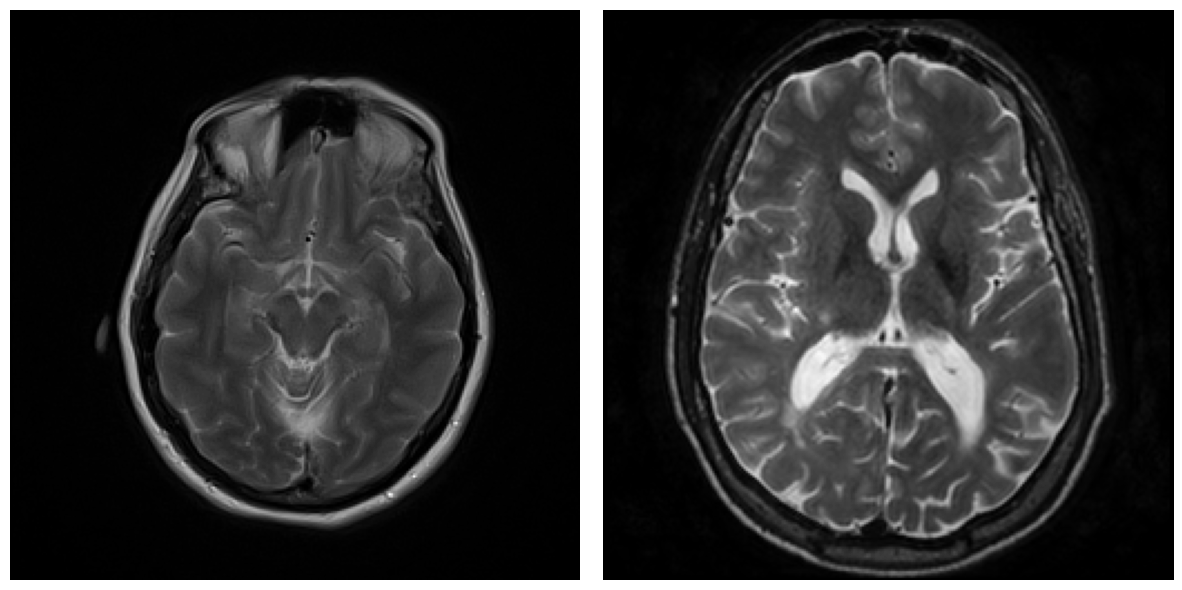

In [7]:
visualize_2_mris(
    img1 = nib.load(muslim_15t.get_filename().replace('.nii','_oriented.nii')),
    img2 = isbi_ph3
)

---

---

# Voxel Size

---

## Z (inferior-superior axis)

---

The file headers indicate 1x1x1 size voxels.  

However, `Supplementary Table 2 for  sequence parameters` specifies the size of dimension 3 for each MRI.

---

### Fix Each Scan and Write to Disk

---

In [8]:
import os
import re
import glob
import nibabel as nib
import pandas as pd

# Load the Excel file with sequence parameters.
ms_muslim_sequence_params_df = pd.read_excel(
    os.path.expanduser('~/dissertation/data/MRI/Muslim_et_al/Supplementary Table 2 for  sequence parameters .xlsx')
)

def get_patient_index(file_path):
    """
    Extracts the patient index from a file name by capturing the digits before the first hyphen.
    Works for both "12-T2.nii" and "12-LesionSeg-T2.nii" formats.
    """
    base = os.path.basename(file_path)
    m = re.match(r"(\d+)", base)
    if m:
        return int(m.group(1))
    else:
        raise ValueError(f"Patient index not found in {base}")

def update_z_axis(file_path, sequence_params_df):
    """
    Updates the z-axis voxel size (and corresponding affine scaling) for a NIfTI image.
    Saves the updated image with a "_z" suffix.
    
    The patient index is extracted with get_patient_index(), which ensures that filenames of both
    the main image and its corresponding LesionSeg file are properly handled.
    
    Parameters:
      file_path (str): Path to the oriented NIfTI file.
      sequence_params_df (DataFrame): DataFrame with sequence parameters.
    """
    # Get the patient index from the file name.
    patient_index = get_patient_index(file_path)
    
    # Get the correct z-axis voxel size from the DataFrame.
    correct_z_size = sequence_params_df.iloc[patient_index, 12]  # spacing between slices

    # Load the image and update the header and affine.
    img = nib.load(file_path)
    data = img.get_fdata()
    affine = img.affine

    # Update the affine directly (update z-scale)
    affine[2, 2] = correct_z_size

    # Set qform and sform directly (updating affine matrix)
    img.set_qform(affine, code=1) # set anatomical coordinate system flag
    img.set_sform(affine, code=1) # set anatomical coordinate system flag

    # corrected_img = nib.Nifti1Image(img.get_fdata(), affine, header)
    corrected_img = nib.Nifti1Image(img.get_fdata(), affine, img.header)

    # Ensure pixdim[3] (z-voxel size) is correct
    corrected_img.header['pixdim'][3] = correct_z_size

    # output filename: add "_z" before the extension if not already present.
    if file_path.endswith(".nii.gz") and not file_path.endswith("_z.nii.gz"):
        corrected_path = file_path.replace(".nii.gz", "_z.nii.gz")
    elif file_path.endswith(".nii") and not file_path.endswith("_z.nii"):
        corrected_path = file_path.replace(".nii", "_z.nii")
    else:
        corrected_path = file_path

    nib.save(corrected_img, corrected_path)
    print(f"Saved corrected file as {os.path.basename(corrected_path)}")

# Find all oriented T2 files.
files_ms_muslim_15t_oriented = glob.glob(
    os.path.expanduser('~/dissertation/data/MRI/Muslim_et_al/Patient-*/*[0-9]-T2_oriented.nii'),
    recursive=True
)

# Process each T2 file and its corresponding LesionSeg file.
for file_path in files_ms_muslim_15t_oriented:
    # Update the oriented T2 file.
    update_z_axis(file_path, ms_muslim_sequence_params_df)

    # Construct the corresponding LesionSeg file path.
    # For example, "12-T2_oriented.nii" becomes "12-LesionSeg-T2_oriented.nii"
    lesionseg_file_path = file_path.replace("-T2_oriented", "-LesionSeg-T2_oriented")
    
    # Update the corresponding LesionSeg file.
    update_z_axis(lesionseg_file_path, ms_muslim_sequence_params_df)

Saved corrected file as 1-T2_oriented_z.nii
Saved corrected file as 1-LesionSeg-T2_oriented_z.nii
Saved corrected file as 10-T2_oriented_z.nii
Saved corrected file as 10-LesionSeg-T2_oriented_z.nii
Saved corrected file as 11-T2_oriented_z.nii
Saved corrected file as 11-LesionSeg-T2_oriented_z.nii
Saved corrected file as 12-T2_oriented_z.nii
Saved corrected file as 12-LesionSeg-T2_oriented_z.nii
Saved corrected file as 13-T2_oriented_z.nii
Saved corrected file as 13-LesionSeg-T2_oriented_z.nii
Saved corrected file as 14-T2_oriented_z.nii
Saved corrected file as 14-LesionSeg-T2_oriented_z.nii
Saved corrected file as 15-T2_oriented_z.nii
Saved corrected file as 15-LesionSeg-T2_oriented_z.nii
Saved corrected file as 16-T2_oriented_z.nii
Saved corrected file as 16-LesionSeg-T2_oriented_z.nii
Saved corrected file as 17-T2_oriented_z.nii
Saved corrected file as 17-LesionSeg-T2_oriented_z.nii
Saved corrected file as 18-T2_oriented_z.nii
Saved corrected file as 18-LesionSeg-T2_oriented_z.nii
Sa

---

---

## X-Y

---

### Problem

---

The X and Y voxel sizes are not available.

However, given the dimensions of the data on these axes and the approximate FOV (skull size vs overall array size), it is apparent that some scans will likely become inviable after rigid registration to a 1x1x1mm standard template.

---

- 2 reasons a scan may become inviable after registration
  - unacceptably oversized output
    - (especially with scans having x/y size > 256)
  - unacceptably oriented output
    - (inaccurate volume size causing errors during registration)

---

### Mitigation

---

Manual inspection of each scan after rigid registration to verify:
- no significant loss of brain tissue
- no major orientation errors

---

Scans not meeting both criteria will not be used.

---

---

---